In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append(r'C:\Users\Alex\git\Masters-EC-Article\source')
from landsat_to_evi import CalculateEVI

In [3]:
import pathlib
import xarray as xr
import matplotlib.pyplot as plt
import rasterio
import rioxarray
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.colors as colors
from functools import reduce
from scipy import stats

In [4]:
import datetime as dt
import matplotlib.dates as mdates

In [5]:
iab3_x_utm_sirgas = 203917.07880027
iab3_y_utm_sirgas = 7545463.6805863

# 1. Inputs

## 1.1. Mapbiomas

In [6]:
tif_file = r"G:\Meu Drive\USP-Mestrado\Masters-Data\Footprint\MapBiomas\iab3_site\IAB1_SIRGAS_23S.tif"
raster_mapbiomas = rasterio.open(tif_file)
mapbiomas = xr.open_rasterio(raster_mapbiomas)

mapbiomas = mapbiomas.where(mapbiomas!=255, drop=True)

C:\Users\Alex\AppData\Local\Temp\ipykernel_5748\1117682111.py:3: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  mapbiomas = xr.open_rasterio(raster_mapbiomas)


In [7]:
# mapbiomas = mapbiomas.assign_coords({'x': mapbiomas.x/1000, 'y': mapbiomas.y/1000})

In [8]:
mapbiomas_bool = ((mapbiomas==3)|(mapbiomas==4))

mapbiomas_bool = mapbiomas_bool.sel(band=1)

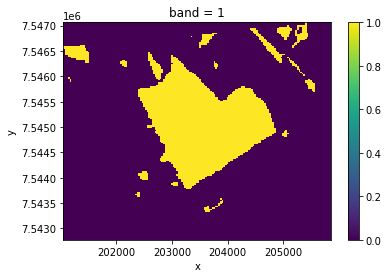

In [9]:
mapbiomas_bool.plot()

## 1.2. EVI

In [10]:
a = CalculateEVI(tif_reference=r"G:\Meu Drive\USP-Mestrado\Masters-Data\Footprint\MapBiomas\iab3_site\IAB1_SIRGAS_23S.tif",
                 meta_reference='MapbiomasLULC_cerrado',
                 files_landsat=[r"G:\Meu Drive\USP-Mestrado\Masters-Data\EVI_LANDSAT_LE07_C02_T1_L2_SR_2019_2021.nc",
                                r"G:\Meu Drive\USP-Mestrado\Masters-Data\EVI_LANDSAT_LC08_C02_T1_L2_SR_2019_2021.nc"],
                 meta_files_landsat=['Landsat7_SR', 'Landsat8_SR'])

Initialized:
Reference image: MapbiomasLULC_cerrado


In [11]:
evi = a.merge_landsat_files()

G:\Meu Drive\USP-Mestrado\Masters-Data\EVI_LANDSAT_LE07_C02_T1_L2_SR_2019_2021.nc Landsat7_SR
G:\Meu Drive\USP-Mestrado\Masters-Data\EVI_LANDSAT_LC08_C02_T1_L2_SR_2019_2021.nc Landsat8_SR
Files merged


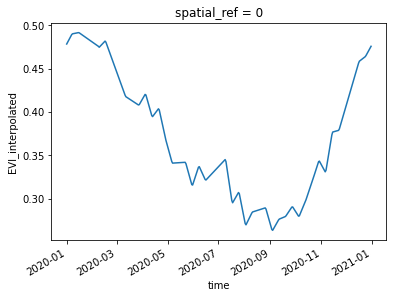

In [12]:
evi_daily = a.interpolate_to_daily(target_year=2020)

In [13]:
evi_daily.time

<xarray.DataArray 'time' (time: 366)>
array(['2020-01-01T00:00:00.000000000', '2020-01-02T00:00:00.000000000',
       '2020-01-03T00:00:00.000000000', ..., '2020-12-29T00:00:00.000000000',
       '2020-12-30T00:00:00.000000000', '2020-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int32 0
  * time         (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31

In [14]:
def xarrayMedian_to_df(xarray_obj, root_name):
    '''
    FUNCTION USED FOR 'RADIUS' AND 'FOOTPRINT BINARY'
    '''
    df_median = xarray_obj.median(dim=('x','y')).to_pandas().reset_index()
    df_25 = xarray_obj.quantile(q=0.25, dim=('x','y')).to_pandas().reset_index()
    df_75 = xarray_obj.quantile(q=0.75, dim=('x','y')).to_pandas().reset_index()
    
    df_median.rename(columns={0:f'{root_name}_median'}, inplace=True)
    df_25.rename(columns={0:f'{root_name}_q25'}, inplace=True)
    df_75.rename(columns={0:f'{root_name}_q75'}, inplace=True)
    
    dfs = [df_median, df_25, df_75]
    
    for i in dfs:
        if 'date' in i.columns:
            i.rename(columns={'date':'time'})
        else:
            pass
    
    df = reduce(lambda left,right: pd.merge(left, right, on=['time']), dfs)
    return df

def xarrayMean_to_df(xarray_obj, root_name):
    '''
    FUNCTION USED FOR 'RADIUS' AND 'FOOTPRINT BINARY'
    '''
    df_mean = xarray_obj.mean(dim=('x','y')).to_pandas().reset_index()
    df_std = xarray_obj.std(dim=('x','y')).to_pandas().reset_index()
    
    df_mean.rename(columns={0:f'{root_name}_mean'}, inplace=True)
    df_std.rename(columns={0:f'{root_name}_std'}, inplace=True)
    
    dfs = [df_mean, df_std]
    
    for i in dfs:
        if 'date' in i.columns:
            i.rename(columns={'date':'time'})
        else:
            pass
        
    df = reduce(lambda left,right: pd.merge(left, right, on=['time']), dfs)
    return df

In [15]:
def xarrayMedian_to_df_weighted(xarray_obj, root_name):
    df_median = xarray_obj.mean().to_pandas().reset_index()
    df_25 = xarray_obj.quantile(q=0.25).to_pandas().reset_index()
    df_75 = xarray_obj.quantile(q=0.75).to_pandas().reset_index()
    
    df_median.rename(columns={0:f'{root_name}_median', 'date':'time'}, inplace=True)
    df_25.rename(columns={0:f'{root_name}_q25', 'date':'time'}, inplace=True)
    df_75.rename(columns={0:f'{root_name}_q75', 'date':'time'}, inplace=True)
    
    dfs = [df_median, df_25, df_75]

    df = reduce(lambda left,right: pd.merge(left, right, on=['time']), dfs)
    
    df['time'] = df['time'].apply(pd.to_datetime)
    
    return df

def xarrayMean_to_df(xarray_obj, root_name):
    '''
 
    '''
    df_mean = xarray_obj.mean().to_pandas().reset_index()
    df_std = xarray_obj.std().to_pandas().reset_index()
    
    df_mean.rename(columns={0:f'{root_name}_mean', 'date':'time'}, inplace=True)
    df_std.rename(columns={0:f'{root_name}_std', 'date':'time'}, inplace=True)
    
    dfs = [df_mean, df_std]
        
    df = reduce(lambda left,right: pd.merge(left, right, on=['time']), dfs)
    
    df['time'] = df['time'].apply(pd.to_datetime)

    return df

# 2. Analysis

## 2.1. Radius

In [16]:
df_evi_radius = xarrayMedian_to_df(xarray_obj=evi_daily, root_name='evi_radius')

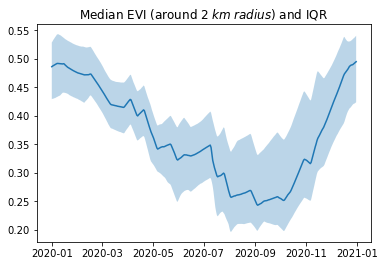

In [17]:
plt.title('Median EVI (around $2\; km\; radius$) and IQR')


plt.plot(df_evi_radius['time'], df_evi_radius['evi_radius_median'])
plt.fill_between(df_evi_radius['time'], df_evi_radius['evi_radius_q25'], df_evi_radius['evi_radius_q75'], alpha=0.3)


In [18]:
df_evi_mean = evi_daily.mean(dim=('x','y')).to_pandas().reset_index()
df_evi_mean.rename(columns={0: 'mean_evi_daily'}, inplace=True)

df_evi_std = evi_daily.std(dim=('x','y')).to_pandas().reset_index()
df_evi_std.rename(columns={0: 'std_evi_daily'}, inplace=True)

df_evi = pd.merge(df_evi_mean, df_evi_std, on='time')

In [19]:
# plt.title('Mean EVI (around $2\; km\; radius$)')
# plt.plot(df_evi['time'], df_evi['mean_evi_daily'])
# plt.fill_between(df_evi['time'], df_evi['mean_evi_daily']-df_evi['std_evi_daily'], df_evi['mean_evi_daily']+df_evi['std_evi_daily'], alpha=0.3)

In [20]:
test = evi_daily.to_numpy()
print(np.shape(test))
count = 0
normaltest_statistic = []
normal_test_p = []
for i in test:
    test_nan = i[~np.isnan(i)]
    # print(test_nan.shape)

    if len(test_nan)>3:
        normality = stats.normaltest(test_nan)
        # print()
        normaltest_statistic.append(normality[0])
        normal_test_p.append(normality[1])
    else:
        normaltest_statistic.append(np.nan)
        normal_test_p.append(np.nan)

(366, 161, 175)


In [21]:
df_evi['normal_statistic'] = normaltest_statistic
df_evi['normal_test_p'] = normal_test_p

## 2.2. Footprint binary

In [22]:
footprint_path = r'G:\Meu Drive\USP-Mestrado\Masters-Data\Footprint\k15_data_v2'

footprint_folder = pathlib.Path(footprint_path)

footprint_file_list = []
for i in range(1,13,1):
    # print(i)
    for file in footprint_folder.rglob(f'*2020*_{i}_*n.nc'):
        # print(file)
        footprint_file_list.append(file)

In [23]:
k15 = xr.open_mfdataset(footprint_file_list)
k15 = k15.sel(band=1)

In [24]:
k15_daily = (((k15['k15_n']>0.001).groupby(k15['datetime'].dt.date).sum(dim='datetime'))>1)

In [25]:
k15_daily = k15_daily.assign_coords({'date': k15_daily.date.astype(np.datetime64)})
k15_daily = k15_daily.rename({'date':'time'})

In [26]:
k15_daily

<xarray.DataArray 'k15_n' (time: 361, y: 161, x: 175)>
dask.array<gt, shape=(361, 161, 175), dtype=bool, chunksize=(1, 161, 175), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 2.008e+05 2.008e+05 2.008e+05 ... 2.058e+05 2.059e+05
  * y        (y) float64 7.547e+06 7.547e+06 7.547e+06 ... 7.543e+06 7.543e+06
    band     int32 1
  * time     (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31

In [27]:
evi_k15 = evi_daily.where(k15_daily)

(7544863.6805863, 7546063.6805863)

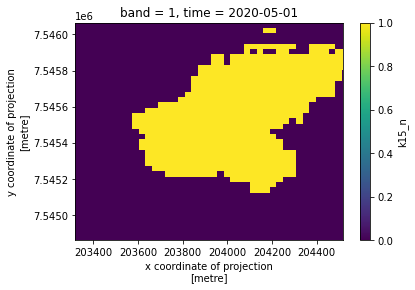

In [28]:
k15_daily.sel(time='2020-05-01').plot()
offset = 600
plt.xlim(iab3_x_utm_sirgas-offset, iab3_x_utm_sirgas+offset)
plt.ylim(iab3_y_utm_sirgas-offset, iab3_y_utm_sirgas+offset)

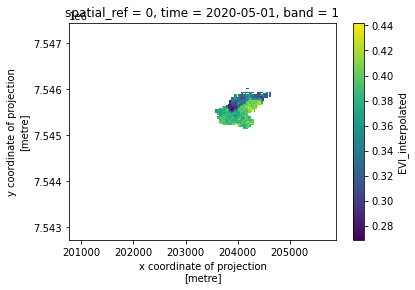

In [29]:
evi_daily.sel(time='2020-05-01').where(k15_daily.sel(time='2020-05-01')).plot()

## 2.3. Footprint binary - without filtering data

In [30]:
df_evi_k15_binary_unfiltered = xarrayMedian_to_df(xarray_obj=evi_k15, root_name='evi_k15_binary_unfiltered')

C:\Users\Alex\anaconda3\envs\Masters\lib\site-packages\numpy\lib\nanfunctions.py:1096: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
C:\Users\Alex\anaconda3\envs\Masters\lib\site-packages\numpy\lib\nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\Alex\anaconda3\envs\Masters\lib\site-packages\numpy\lib\nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


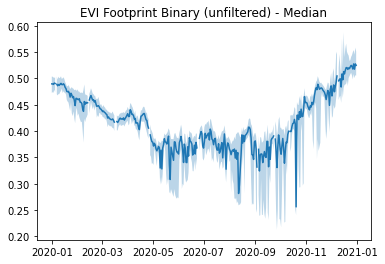

In [31]:
plt.title('EVI Footprint Binary (unfiltered) - Median')

plt.plot(df_evi_k15_binary_unfiltered['time'], df_evi_k15_binary_unfiltered['evi_k15_binary_unfiltered_median'])
plt.fill_between(df_evi_k15_binary_unfiltered['time'], df_evi_k15_binary_unfiltered['evi_k15_binary_unfiltered_q25'], df_evi_k15_binary_unfiltered['evi_k15_binary_unfiltered_q75'], alpha=0.3)

## 2.4. Footprint binary - filtering data

In [32]:
evi_daily_filtered_acc = evi_daily*mapbiomas_bool
evi_daily_filtered_rej = evi_daily*~mapbiomas_bool

evi_k15_filtered_acc = evi_daily_filtered_acc.where(k15_daily).where(evi_daily_filtered_acc!=0)
evi_k15_filtered_rej = evi_daily_filtered_rej.where(k15_daily).where(evi_daily_filtered_rej!=0)

In [33]:
df_evi_k15_binary_filtered_acc = xarrayMedian_to_df(xarray_obj=evi_k15_filtered_acc, 
                                                    root_name='evi_k15_binary_filteredAcc')

df_evi_k15_binary_filtered_rej = xarrayMedian_to_df(xarray_obj=evi_k15_filtered_rej, 
                                                    root_name='evi_k15_binary_filteredRej')

C:\Users\Alex\anaconda3\envs\Masters\lib\site-packages\numpy\lib\nanfunctions.py:1096: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
C:\Users\Alex\anaconda3\envs\Masters\lib\site-packages\numpy\lib\nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\Alex\anaconda3\envs\Masters\lib\site-packages\numpy\lib\nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\Alex\anaconda3\envs\Masters\lib\site-packages\numpy\lib\nanfunctions.py:1096: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
C:\Users\Alex\anaconda3\envs\Masters\lib\site-packages\numpy\lib\nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\Alex\anaconda3\envs\Mast

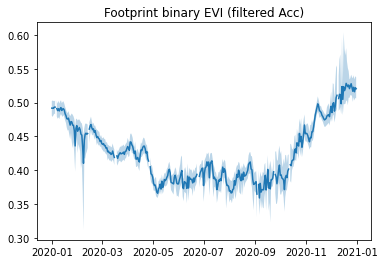

In [34]:
plt.title('Footprint binary EVI (filtered Acc)')

plt.plot(df_evi_k15_binary_filtered_acc['time'], df_evi_k15_binary_filtered_acc['evi_k15_binary_filteredAcc_median'])
plt.fill_between(df_evi_k15_binary_filtered_acc['time'], df_evi_k15_binary_filtered_acc['evi_k15_binary_filteredAcc_q25'], df_evi_k15_binary_filtered_acc['evi_k15_binary_filteredAcc_q75'], alpha=0.3)

# plt.plot(df_evi_k15_filteredAcc['time'], df_evi_k15_filteredAcc['mean_k15_evi_daily_filteredAcc'])
# plt.fill_between(df_evi_k15_filteredAcc['time'], df_evi_k15_filteredAcc['mean_k15_evi_daily_filteredAcc']-df_evi_k15_filteredAcc['std_k15_evi_daily_filteredAcc'], df_evi_k15_filteredAcc['mean_k15_evi_daily_filteredAcc']+df_evi_k15_filteredAcc['std_k15_evi_daily_filteredAcc'], alpha=0.3)

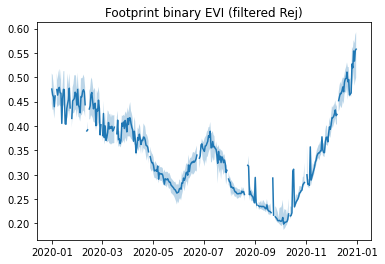

In [35]:
plt.title('Footprint binary EVI (filtered Rej)')
plt.plot(df_evi_k15_binary_filtered_rej['time'], df_evi_k15_binary_filtered_rej['evi_k15_binary_filteredRej_median'])
plt.fill_between(df_evi_k15_binary_filtered_rej['time'], df_evi_k15_binary_filtered_rej['evi_k15_binary_filteredRej_q25'], df_evi_k15_binary_filtered_rej['evi_k15_binary_filteredRej_q75'], alpha=0.3)

## 2.5. Footprint integrated

### 2.5.1. Accepted and reject (separated)

In [36]:
k15_acc = (k15*mapbiomas_bool).sum(dim=('x','y'))['k15_n']
k15_rej = (k15*~mapbiomas_bool).sum(dim=('x','y'))['k15_n']

k15_acc = k15_acc.rename({'datetime':'time'})
k15_rej = k15_rej.rename({'datetime':'time'})

C:\Users\Alex\anaconda3\envs\Masters\lib\site-packages\xarray\core\indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\Alex\anaconda3\envs\Masters\lib\site-packages\xarray\core\indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value

In [39]:
#k15_evi_folder = pathlib.Path(r"C:\Users\Alex\Desktop\k15_data_v2\k15_evi")
k15_evi_folder = pathlib.Path(r"G:\Meu Drive\USP-Mestrado\Masters-Data\Footprint\k15_data\k15_evi")
k15_evi_files = []
for i in k15_evi_folder.rglob('*.nc'):
    k15_evi_files.append(i)
    # print(i)


In [40]:
k15_evi = xr.open_mfdataset(k15_evi_files)

In [41]:
k15_evi_acc = k15_evi*mapbiomas_bool

k15_evi_rej = k15_evi*~mapbiomas_bool

C:\Users\Alex\anaconda3\envs\Masters\lib\site-packages\xarray\core\indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\Alex\anaconda3\envs\Masters\lib\site-packages\xarray\core\indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value

In [42]:
k15_evi_acc_sum = k15_evi_acc.sum(dim=('x','y'))['evi_k15']
k15_evi_rej_sum = k15_evi_rej.sum(dim=('x','y'))['evi_k15']

k15_evi_acc_norm = k15_evi_acc_sum/k15_acc
k15_evi_rej_norm = k15_evi_rej_sum/k15_rej

In [43]:
k15_evi_acc_norm_daily = k15_evi_acc_norm.groupby(k15_evi_acc_norm['time'].dt.date)
k15_evi_rej_norm_daily = k15_evi_rej_norm.groupby(k15_evi_rej_norm['time'].dt.date)



In [44]:
df_evi_k15_weighted_filtered_acc = xarrayMedian_to_df_weighted(xarray_obj=k15_evi_acc_norm_daily,
                                                               root_name='evi_k15_weighted_filteredAcc')
df_evi_k15_weighted_filtered_rej = xarrayMedian_to_df_weighted(xarray_obj=k15_evi_rej_norm_daily,
                                                               root_name='evi_k15_weighted_filteredRej')

C:\Users\Alex\anaconda3\envs\Masters\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\Alex\anaconda3\envs\Masters\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\Alex\anaconda3\envs\Masters\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


### 2.5.2. Without separation

In [45]:
k15_evi_sum = k15_evi.sum(dim=('x','y'))['evi_k15']


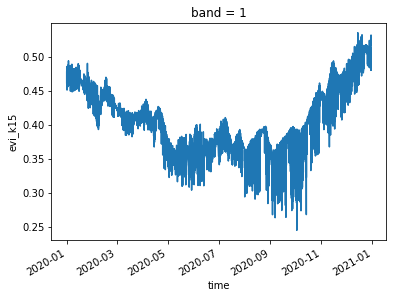

In [46]:
k15_evi_sum.plot()

In [47]:
k15_evi_norm_daily = k15_evi_sum.groupby(k15_evi_sum['time'].dt.date)

In [48]:
df_evi_k15_weighted_unfiltered = xarrayMedian_to_df_weighted(xarray_obj=k15_evi_norm_daily,
                                                             root_name='evi_k15_weighted_unfiltered')

#  Plotting together all data

In [49]:
dfs = [df_evi_radius,
       # df_evi_k15_binary_unfiltered,
       # df_evi_k15_binary_filtered_acc,
       # df_evi_k15_binary_filtered_rej,
       df_evi_k15_weighted_unfiltered,
       df_evi_k15_weighted_filtered_acc,
       df_evi_k15_weighted_filtered_rej]

df_all_evi = reduce(lambda left,right: pd.merge(left, right, on=['time']), dfs)

In [50]:
# df_all_evi.to_csv(r'G:\Meu Drive\USP-Mestrado\Masters-Data\EVI\processed_data\sr\V2\evi_all_daily_2020_median.csv')

In [51]:
df_all_evi.columns

Index(['time', 'evi_radius_median', 'evi_radius_q25', 'evi_radius_q75',
       'evi_k15_weighted_unfiltered_median', 'evi_k15_weighted_unfiltered_q25',
       'evi_k15_weighted_unfiltered_q75',
       'evi_k15_weighted_filteredAcc_median',
       'evi_k15_weighted_filteredAcc_q25', 'evi_k15_weighted_filteredAcc_q75',
       'evi_k15_weighted_filteredRej_median',
       'evi_k15_weighted_filteredRej_q25', 'evi_k15_weighted_filteredRej_q75'],
      dtype='object')

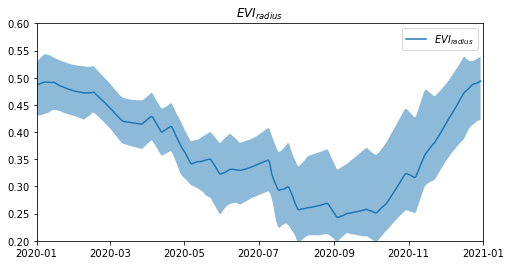

In [52]:
fig, ax = plt.subplots(figsize=(8,4))

ax.set_title('$EVI_{radius}$')

ax.plot(df_all_evi['time'], df_all_evi['evi_radius_median'],
        label='$EVI_{radius}$')
ax.fill_between(df_all_evi['time'], 
                df_all_evi['evi_radius_q25'], 
                df_all_evi['evi_radius_q75'], 
                alpha=0.5)

ax.set_ylim((0.2,0.6))
ax.set_xlim((dt.datetime(2020,1,1),dt.datetime(2021,1,1)))

ax.legend()

KeyError: 'evi_k15_binary_filteredAcc_median'

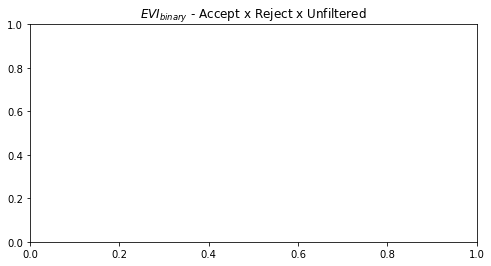

In [54]:
fig, ax = plt.subplots(figsize=(8,4))

ax.set_title('$EVI_{binary}$ - Accept x Reject x Unfiltered')

ax.plot(df_all_evi['time'], df_all_evi['evi_k15_binary_filteredAcc_median'],
        label='$EVI_{binary}$ - Accept')
ax.fill_between(df_all_evi['time'], 
                 df_all_evi['evi_k15_binary_filteredAcc_q25'], 
                 df_all_evi['evi_k15_binary_filteredAcc_q75'], 
                alpha=0.3)

ax.plot(df_all_evi['time'], df_all_evi['evi_k15_binary_filteredRej_median'], 
        label='$EVI_{binary}$ - Reject')
ax.fill_between(df_all_evi['time'], 
                 df_all_evi['evi_k15_binary_filteredRej_q25'], 
                 df_all_evi['evi_k15_binary_filteredRej_q75'], 
                alpha=0.3)

ax.plot(df_all_evi['time'], df_all_evi['evi_k15_binary_unfiltered_median'],
        label='$EVI_{binary}$ - Unfiltered')
ax.fill_between(df_all_evi['time'], 
                 df_all_evi['evi_k15_binary_unfiltered_q25'], 
                 df_all_evi['evi_k15_binary_unfiltered_q75'], 
                alpha=0.3)

ax.set_ylim((0.2,0.6))
ax.set_xlim((dt.datetime(2020,1,1),dt.datetime(2021,1,1)))

ax.legend()

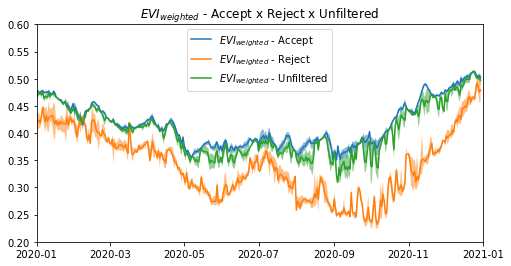

In [55]:
fig, ax = plt.subplots(figsize=(8,4))

ax.set_title('$EVI_{weighted}$ - Accept x Reject x Unfiltered')

ax.plot(df_all_evi['time'], df_all_evi['evi_k15_weighted_filteredAcc_median'],
        label='$EVI_{weighted}$ - Accept')
ax.fill_between(df_all_evi['time'], 
                df_all_evi['evi_k15_weighted_filteredAcc_q25'], 
                df_all_evi['evi_k15_weighted_filteredAcc_q75'], 
                alpha=0.5)

ax.plot(df_all_evi['time'], df_all_evi['evi_k15_weighted_filteredRej_median'],
        label='$EVI_{weighted}$ - Reject')
ax.fill_between(df_all_evi['time'], 
                df_all_evi['evi_k15_weighted_filteredRej_q25'], 
                df_all_evi['evi_k15_weighted_filteredRej_q75'], 
                alpha=0.5)

ax.plot(df_all_evi['time'], df_all_evi['evi_k15_weighted_unfiltered_median'],
        label='$EVI_{weighted}$ - Unfiltered')
ax.fill_between(df_all_evi['time'], 
                df_all_evi['evi_k15_weighted_unfiltered_q25'], 
                df_all_evi['evi_k15_weighted_unfiltered_q75'], 
                alpha=0.5)

ax.set_ylim((0.2,0.6))
ax.set_xlim((dt.datetime(2020,1,1),dt.datetime(2021,1,1)))
ax.legend()

In [56]:
df_all_evi.columns

Index(['time', 'evi_radius_median', 'evi_radius_q25', 'evi_radius_q75',
       'evi_k15_weighted_unfiltered_median', 'evi_k15_weighted_unfiltered_q25',
       'evi_k15_weighted_unfiltered_q75',
       'evi_k15_weighted_filteredAcc_median',
       'evi_k15_weighted_filteredAcc_q25', 'evi_k15_weighted_filteredAcc_q75',
       'evi_k15_weighted_filteredRej_median',
       'evi_k15_weighted_filteredRej_q25', 'evi_k15_weighted_filteredRej_q75'],
      dtype='object')

In [57]:
variables_binary = ['evi_k15_binary_unfiltered_median', 'evi_k15_binary_filteredAcc_median','evi_k15_binary_filteredRej_median']
variables_binary_q25 = ['evi_k15_binary_unfiltered_q25','evi_k15_binary_filteredAcc_q25','evi_k15_binary_filteredRej_q25']
variables_binary_q75 = ['evi_k15_binary_unfiltered_q75','evi_k15_binary_filteredAcc_q75','evi_k15_binary_filteredRej_q75']

variables_weighted = ['evi_k15_weighted_unfiltered_median', 'evi_k15_weighted_filteredAcc_median','evi_k15_weighted_filteredRej_median']
variables_weighted_q25 = ['evi_k15_weighted_unfiltered_q25','evi_k15_weighted_filteredAcc_q25','evi_k15_weighted_filteredRej_q25']
variables_weighted_q75 = ['evi_k15_weighted_unfiltered_q75','evi_k15_weighted_filteredAcc_q75','evi_k15_weighted_filteredRej_q75']

variables = [variables_binary,variables_weighted]
# variables_q25 = [variables_binary_q25, variables_weighted_q25]
binary_labels = ['$EVI_{binary}$ - Unfiltered','$EVI_{binary}$ - Accept','$EVI_{binary}$ - Reject']
weighted_labels = ['$EVI_{weighted}$ - Unfiltered','$EVI_{weighted}$ - Accept','$EVI_{weighted}$ - Reject']
variables_labels = [binary_labels, weighted_labels]

KeyError: "['evi_k15_binary_unfiltered_median'] not in index"

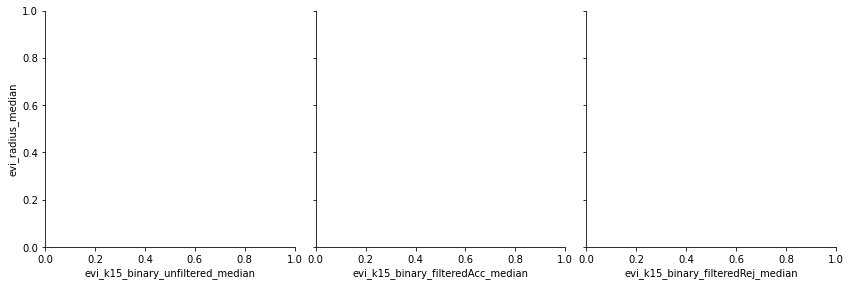

In [58]:

for v,label in zip(variables, variables_labels):
    g = sns.PairGrid(data=df_all_evi,
                     y_vars=['evi_radius_median'],
                     x_vars=v, aspect=1, height=4)

    bindwidth=0.015
    
    def func(x, y, **kws):
        ax = plt.gca()
        ax.plot([0,1],[0,1], color='red', linestyle='--')
        ax.set_xlim((0.2, 0.6))
        ax.set_ylim((0.2, 0.6))
        # print(x.name[:-6])
        sns.histplot(data=df_all_evi, 
                     y='evi_radius_q25', 
                     x=f'{x.name[:-6]}q25', 
                     color='.01', binwidth=bindwidth,zorder=0, binrange=(0,1))
        sns.histplot(data=df_all_evi, 
                     y='evi_radius_q75', 
                     x=f'{x.name[:-6]}q75', 
                     color='.01', binwidth=bindwidth,zorder=0, binrange=(0,1))

    
    g.map_offdiag(sns.histplot, binwidth=bindwidth, cmap='Reds', binrange=(0,1))
    g.map_offdiag(func)
    
    g.axes[0,0].set_ylabel('$EVI_{Radius}$')
    for i, l in enumerate(label):
        g.axes[0,i].set_xlabel(l)

In [59]:
sns.set_theme()

In [60]:
final_imgFolder = pathlib.Path(r"G:\Meu Drive\USP-Mestrado\Masters-Data\Imgs\Final")

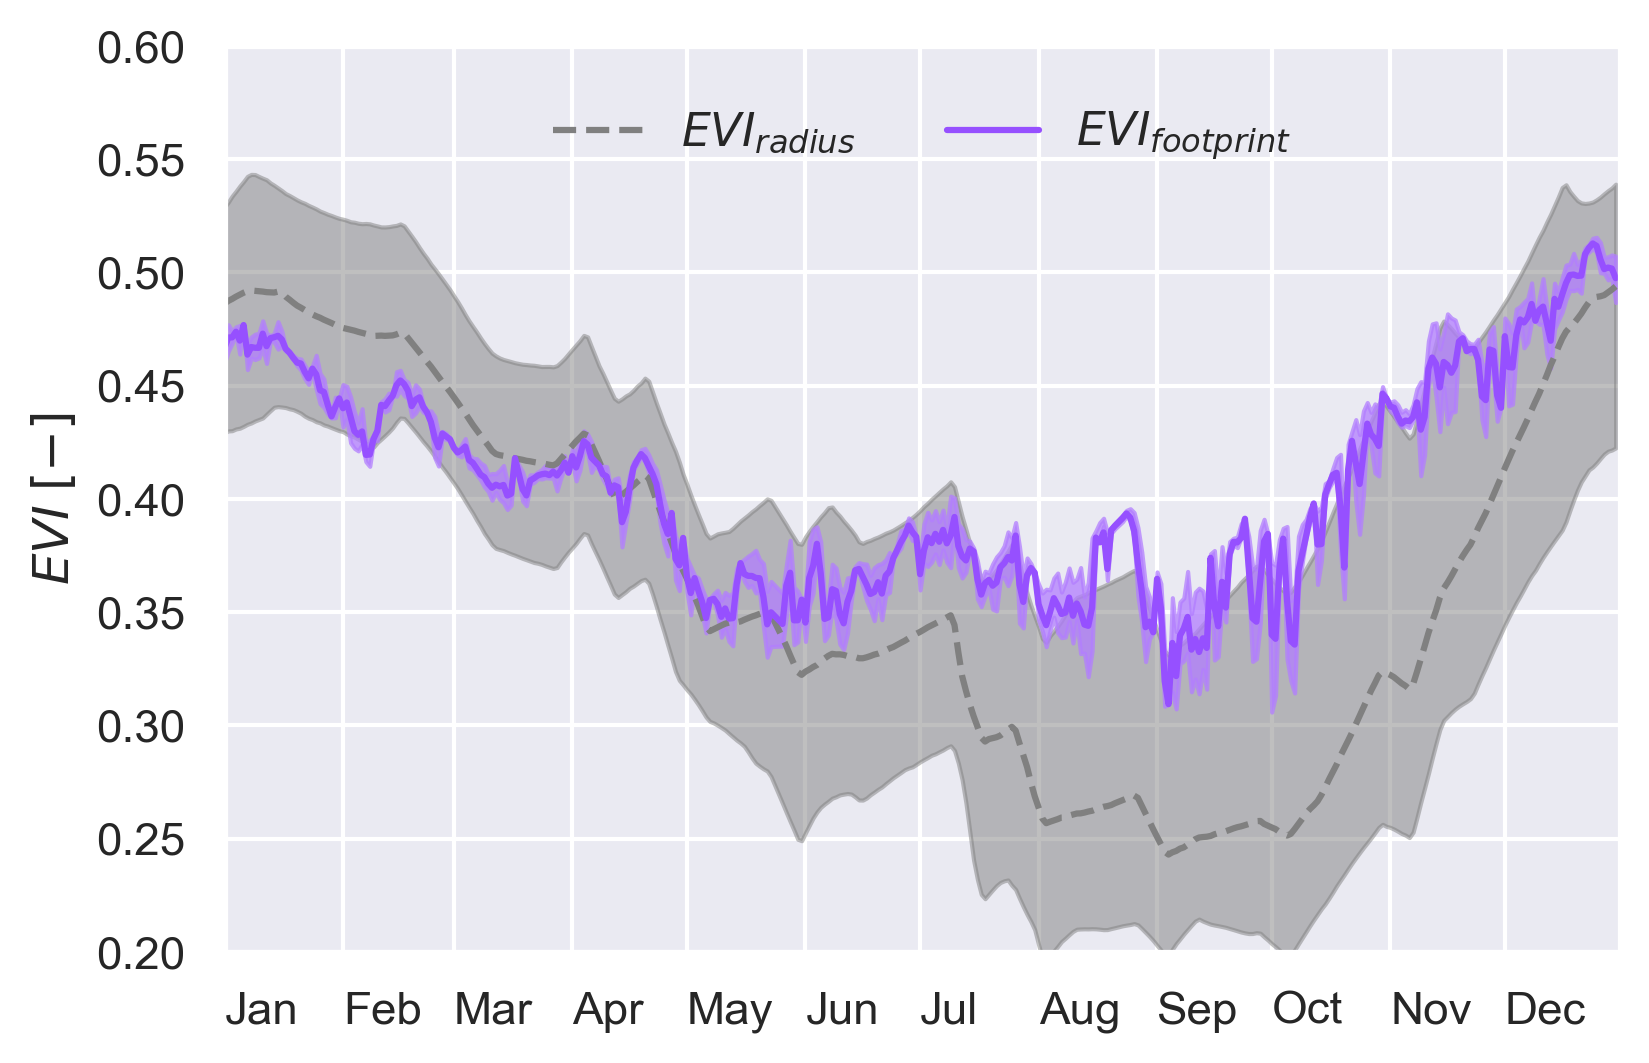

In [62]:
fig, ax = plt.subplots(figsize=(6,4), dpi=300)

g=sns.lineplot(data=df_all_evi, x='time', y='evi_radius_median',
             label='$EVI_{radius}$',ax=ax, color='grey', linestyle='--')
ax.fill_between(df_all_evi['time'], 
                df_all_evi['evi_radius_q25'], 
                df_all_evi['evi_radius_q75'], 
                alpha=0.5, color='Grey')

sns.lineplot(data=df_all_evi, x='time',y='evi_k15_weighted_unfiltered_median',ax=ax, color='#9650FF',
            label='$EVI_{footprint}$')
ax.fill_between(df_all_evi['time'], 
                df_all_evi['evi_k15_weighted_unfiltered_q25'], 
                df_all_evi['evi_k15_weighted_unfiltered_q75'], 
                alpha=0.75, color='#B27EFF')


sns.move_legend(g, "upper center", ncol=4, title=None, frameon=False, bbox_to_anchor=(0.5,0.975))

# g.set(xticks=[dt.datetime(2020,i,1) for i in range(1,13,1)])
# g.set_xticklabels(labels=[f''])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
# ax.tick_params(direction='right', pad=15)
plt.setp(ax.xaxis.get_majorticklabels(), ha='left')
g.set_ylabel('$EVI\; [-]$')
g.set_xlabel('')
ax.set_ylim(0.2,0.6)
ax.set_xlim((dt.datetime(2020,1,1), dt.datetime(2020,12,31)))

#fig.savefig(final_imgFolder/'evi_radiusvsfootprint.png')